In [26]:
import pandas as pd
import numpy as np
import datetime as dt
import wrds
import psycopg2 
import matplotlib.pyplot as plt
from pathlib import Path
import sas7bdat

In [20]:
###################
# Connect to WRDS #
###################
conn=wrds.Connection()
#jasonjia1
#[.]+wrds

Enter your WRDS username [jasonjia]:jasonjia1
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done


In [7]:
# Read S34Type1 Dataset
# rdate = Holdings Report Date
# fdate = Vintage Date
s34type1 = conn.raw_sql("""
                    select fdate, rdate, typecode, mgrno 
                    from tfn.s34type1 
                    where typecode IS NOT NULL
                    """, date_cols = ['fdate', 'rdate'])
s34type1[['typecode','mgrno']]=s34type1[['typecode','mgrno']].astype(int)
s34type1 = s34type1[s34type1['rdate']==s34type1['fdate']]

In [8]:
# Count the number of institutions by typecode
instcounts = s34type1.groupby(['rdate','typecode'])['mgrno'].count()\
.to_frame().reset_index()
instcounts=instcounts.rename(columns={'mgrno':'numero'})
instcounts

,rdate,typecode,numero
0,1980-03-31,1,197
1,1980-03-31,2,60
2,1980-03-31,3,44
3,1980-03-31,4,103
4,1980-03-31,5,63
...,...,...,...
834,2021-12-31,1,113
835,2021-12-31,2,28
836,2021-12-31,3,242
837,2021-12-31,4,3439


In [9]:
# Reshape (transpose) the table 
# Report number by typecode per column
ts = instcounts.pivot(index='rdate', columns='typecode', values='numero')

In [10]:
# Rename the columns by label
ts = ts.rename(columns={1:'Bank',\
                        2:'Insurance',\
                        3:'Mutual Funds', \
                        4:'Investment Advisors',\
                        5:'Others'}).reset_index()

In [11]:
# Fill in 0 for missing observation
ts = ts.fillna(0)
ts.head(20)

typecode,rdate,Bank,Insurance,Mutual Funds,Investment Advisors,Others
0,1980-03-31,197.0,60.0,44.0,103.0,63.0
1,1980-06-30,195.0,64.0,49.0,111.0,62.0
2,1980-09-30,204.0,67.0,50.0,113.0,61.0
3,1980-12-31,217.0,65.0,49.0,122.0,75.0
4,1981-03-31,214.0,61.0,49.0,119.0,82.0
5,1981-06-30,209.0,57.0,50.0,126.0,84.0
6,1981-09-30,206.0,56.0,54.0,130.0,77.0
7,1981-12-31,216.0,60.0,53.0,150.0,82.0
8,1982-03-31,219.0,61.0,50.0,143.0,78.0
9,1982-06-30,210.0,61.0,49.0,148.0,76.0


In [12]:
# Calculate Total by adding up all categories
ts['Total']=ts['Bank']+ts['Insurance']+ts['Mutual Funds']+ts['Investment Advisors']+ts['Others']

# Year and Month information from rdate
ts['Month']=ts['rdate'].dt.month
ts['Year']=ts['rdate'].dt.year

In [13]:
ts=ts.set_index('rdate')


In [14]:
ts

typecode,Bank,Insurance,Mutual Funds,Investment Advisors,Others,Total,Month,Year
rdate,,,,,,,,
1980-03-31,197.0,60.0,44.0,103.0,63.0,467.0,3,1980
1980-06-30,195.0,64.0,49.0,111.0,62.0,481.0,6,1980
1980-09-30,204.0,67.0,50.0,113.0,61.0,495.0,9,1980
1980-12-31,217.0,65.0,49.0,122.0,75.0,528.0,12,1980
1981-03-31,214.0,61.0,49.0,119.0,82.0,525.0,3,1981
...,...,...,...,...,...,...,...,...
2020-12-31,110.0,25.0,128.0,2897.0,2821.0,5981.0,12,2020
2021-03-31,110.0,25.0,135.0,2928.0,2803.0,6001.0,3,2021
2021-06-30,107.0,25.0,135.0,2937.0,2799.0,6003.0,6,2021


In [15]:
# Results at Year End
ts_yend = ts[ts['Month']==12].drop(['Month'],axis=1)
ts_yend.head()

typecode,Bank,Insurance,Mutual Funds,Investment Advisors,Others,Total,Year
rdate,,,,,,,
1980-12-31,217.0,65.0,49.0,122.0,75.0,528.0,1980
1981-12-31,216.0,60.0,53.0,150.0,82.0,561.0,1981
1982-12-31,217.0,60.0,54.0,172.0,78.0,581.0,1982
1983-12-31,227.0,63.0,54.0,218.0,80.0,642.0,1983
1984-12-31,225.0,63.0,53.0,266.0,89.0,696.0,1984


In [16]:
ts_yend.to_csv('~/13f_intro.csv')

In [17]:
ts = ts.drop(['Month', 'Year'], axis=1)

<AxesSubplot:title={'center':'Time Series of the Number of Institutions by Manager Type'}, xlabel='rdate'>

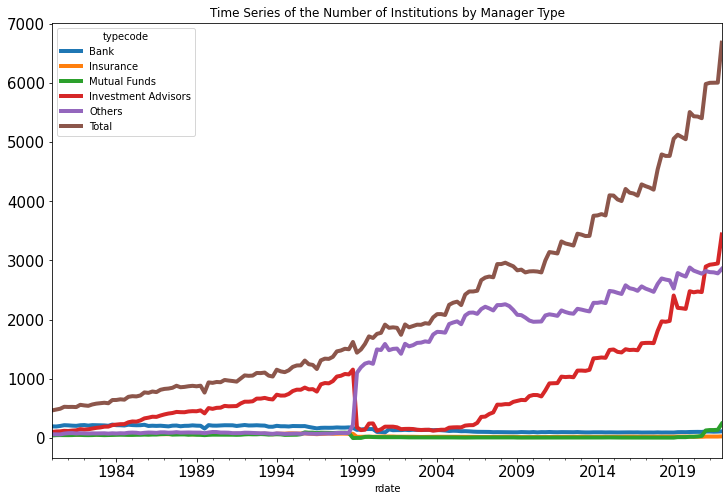

In [18]:
# Plot the time series of the charts
ts.plot(kind='line', title = 'Time Series of the Number of Institutions by Manager Type',\
        linewidth=4, figsize=(12,8), fontsize=15)